# Preamble
Setting up:
 - Required modules
 - Folder paths
 - Useful functions
 - Creating simulator instance and reading in the data

In [34]:
# Required imports
import os
import json
import numpy as np
import pandas as pd
import random
import imageio
import magnum as mn
from PIL import Image
from matplotlib import pyplot as plt

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
import magnum as mn

In [2]:
# setting up folder paths
habitat_dir_path = "/home/wes/habitat/data/"
scene_dir_path = os.path.join(habitat_dir_path, f"scene_datasets/mp3d/")
rxr_data_path = "/media/wes/Lexar/rxr_data/rxr-data/"
output_path = "/home/wes/Documents/git_ws/OCOM5300M_ResearchProject/outputs/"

mp3d_scene_config = os.path.join(scene_dir_path, f"mp3d.scene_dataset_config.json")

def get_scene_path(scene_dir_path, scene_id):
    return os.path.join(scene_dir_path, f"{scene_id}/{scene_id}.glb")

In [3]:
scene_id = "2t7WUuJeko7"
scene_path = get_scene_path(scene_dir_path, scene_id)

print(f"mp3d_scene_config: {mp3d_scene_config}, \t exists: {os.path.exists(mp3d_scene_config)}")
print(f"scene_path: {scene_path}, \t exists: {os.path.exists(scene_path)}")

mp3d_scene_config: /home/wes/habitat/data/scene_datasets/mp3d/mp3d.scene_dataset_config.json, 	 exists: True
scene_path: /home/wes/habitat/data/scene_datasets/mp3d/2t7WUuJeko7/2t7WUuJeko7.glb, 	 exists: True


## Preamble: Utility Functions
### Display observations

In [4]:
# Change to do something like this maybe: https://stackoverflow.com/a/41432704
#    i.e. show multiple subplots on one plot
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)


if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument("--no-make-video", dest="make_video", action="store_false")
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    do_make_video = args.make_video
else:
    show_video = False
    do_make_video = False
    display = False

# import the maps module alone for topdown mapping
if display:
    from habitat.utils.visualizations import maps

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


### Configuring Simulator Settings

In [5]:
# Default sim settings
rgb_sensor = True
depth_sensor = True
semantic_sensor = False
seed = 1

sim_settings = {
    "width": 256,  # Spatial resolution of the observations
    "height": 256,
    "scene": scene_path,  # Scene path
    "scene_dataset": mp3d_scene_config,  # the scene dataset configuration files
    "default_agent": 0,
    "sensor_height": 1.5,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "semantic_sensor": semantic_sensor,  # Semantic sensor
    "seed": seed,  # used in the random navigation
    "enable_physics": False,  # kinematics only    
}

In [6]:
# Sim config factory?
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.scene_dataset_config_file = settings["scene_dataset"]
    sim_cfg.enable_physics = settings["enable_physics"]

    # sensor specs
    sensor_specs = []

    color_sensor_spec = habitat_sim.CameraSensorSpec()
    color_sensor_spec.uuid = "color_sensor"
    color_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(color_sensor_spec)

    depth_sensor_spec = habitat_sim.CameraSensorSpec()
    depth_sensor_spec.uuid = "depth_sensor"
    depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
    depth_sensor_spec.resolution = [settings["height"], settings["width"]]
    depth_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(depth_sensor_spec)

    #agent movement
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward" : habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left":habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
        "turn_right":habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=30.0)
        )
    }
    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


### Loading annotations file

In [7]:
# Utility function to read rxr data and return it in a dataframe
def json_to_df(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))

    return pd.DataFrame(data)    

### Translating `rxr` viwpoint IDs into `habitat-sim` positions

## Reading in the `rxr` data

In [8]:
# Checking file path
annotations_fname = "rxr_train_guide.jsonl/rxr_train_guide.json"
annotations_path = os.path.join(rxr_data_path, annotations_fname)
print(f'Checking existence of {annotations_path}: \t {os.path.exists(annotations_path)}')

Checking existence of /media/wes/Lexar/rxr_data/rxr-data/rxr_train_guide.jsonl/rxr_train_guide.json: 	 True


In [10]:
df_rxr = json_to_df(annotations_path)
df_rxr.head(5)

,path_id,split,scan,heading,path,instruction_id,annotator_id,language,instruction,timed_instruction,edit_distance
0,0,train,SN83YJsR3w2,2.631565,"[4471fcf26b3847ed88ce41eca5ecb13d, b2b0b597ef2...",0,0,en-US,You will start by standing in front of a glass...,"[{'end_time': 1.5, 'word': 'You', 'start_time'...",0.076923
1,3,train,8WUmhLawc2A,5.346564,"[5456afbdce1d49489a6d1a178b3a7840, c42200c0f39...",6,12,hi-IN,भोजनकक्ष के कोने में दाएं हाथ में लकड़ी के खाने...,"[{'end_time': 63.4, 'word': 'भोजनकक्ष', 'start...",0.144144
2,3,train,8WUmhLawc2A,5.346564,"[5456afbdce1d49489a6d1a178b3a7840, c42200c0f39...",7,14,hi-IN,"आप अभी खाने के मेज़ के पास ठैहरे होवे हैं,यहाँ ...","[{'word': 'आप', 'end_time': 10.1, 'start_time'...",0.158140
3,3,train,8WUmhLawc2A,5.346564,"[5456afbdce1d49489a6d1a178b3a7840, c42200c0f39...",8,16,hi-IN,आपके दाए तरफ लकड़ी का मेज है। यहाँ से आगे बढिये...,"[{'word': 'आपके', 'end_time': 1.7, 'start_time...",0.259494
4,4,train,uNb9QFRL6hY,3.281999,"[fb41635bb9844f1ea9777cbdb06a89a7, fa0c95d44b3...",9,18,en-IN,"Right now you are in front of the window, now ...","[{'start_time': 1.4, 'end_time': 2.4, 'word': ...",0.156800


In [11]:
df_rxr = df_rxr[df_rxr['language']=='en-US']

In [12]:
df_instruction = df_rxr[df_rxr['scan']=='5q7pvUzZiYa']

In [59]:
pose_dir_path = '/media/wes/Lexar/rxr_data/rxr-data/pose_traces/rxr_train/'
instruction_id = df_instruction['instruction_id'].iloc[0]
instruct_id = ('000000' + str(instruction_id))[-6:]
print(f'pose_dir_path: {pose_dir_path}, \t exists: {os.path.exists(pose_dir_path)}')
print(f'instruct_id: {instruct_id}')

pose_dir_path: /media/wes/Lexar/rxr_data/rxr-data/pose_traces/rxr_train/, 	 exists: True
instruct_id: 000297


In [15]:
pose_trace_path = os.path.join(pose_dir_path, f'{instruction_id}_guide_pose_trace.npz')
print(f'{pose_trace_path} exists: {os.path.exists(pose_trace_path)}')

/media/wes/Lexar/rxr_data/rxr-data/pose_traces/rxr_train/000297_guide_pose_trace.npz exists: True


In [16]:
pose_trace = np.load(pose_trace_path)
poses = pose_trace['extrinsic_matrix']
print(poses.shape)

(6482, 4, 4)


In [119]:
poses[0]==poses[63]

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [133]:
poses[64]

array([[-5.90173364e-01, -7.92529155e-03,  8.07237625e-01,
         1.03697419e-01],
       [-8.67361738e-19,  9.99951780e-01,  9.81731899e-03,
         4.75754118e+00],
       [-8.07276547e-01,  5.79392025e-03, -5.90144932e-01,
        -8.06029797e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

## Creating simulator instance

In [18]:
# Create configuration
cfg = make_cfg(sim_settings)

In [19]:
# Create simulator instance
sim = habitat_sim.Simulator(cfg)

Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.107.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[20:47:08:884915]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


# Test - turning viewpoint IDs into positions

## Old - R2R Connectivity

In [16]:
viewpoint_id = df_rxr[df_rxr['scan']==scene_id]['path'].iloc[0][0]
print(viewpoint_id)

0e92a69a50414253a23043758f111cec


In [17]:
connectivity_dir_path = os.path.join(habitat_dir_path, 'Matterport3DSimulator/connectivity/')
connectivity_path = os.path.join(connectivity_dir_path, f'{scene_id}_connectivity.json')
print(f'connectivity_path: {connectivity_path}, \t Exists: {os.path.exists(connectivity_path)}')

connectivity_path: /home/wes/habitat/data/Matterport3DSimulator/connectivity/17DRP5sb8fy_connectivity.json, 	 Exists: True


In [18]:
with open(connectivity_path, 'r') as file:
    df_con = pd.DataFrame(json.load(file))

df_con.head()

,image_id,pose,included,visible,unobstructed,height
0,10c252c90fa24ef3b698c6f54d984c5c,"[-0.934268, -0.00147015, -0.35657, -5.48891, 0...",True,"[False, False, True, False, False, False, Fals...","[False, False, False, False, False, False, Fal...",1.535738
1,0e92a69a50414253a23043758f111cec,"[0.02821, 0.0215087, 0.999371, -2.20971, -0.99...",True,"[False, False, False, True, False, True, True,...","[False, False, False, False, False, False, Fal...",1.581438
2,51857544c192476faebf212acb1b3d90,"[-0.999869, -0.00709109, 0.014624, -8.74239, -...",True,"[True, False, False, False, False, False, Fals...","[False, False, False, False, False, False, Fal...",1.531229
3,558ba0761bf24428b9cf91e60333ea25,"[-0.0320212, -0.0104669, -0.999433, 2.41405, 0...",True,"[False, True, False, False, False, True, True,...","[False, False, False, False, False, False, Tru...",1.595108
4,3577de361e1a46b1be544d37731bfde6,"[-0.98209, 0.0184798, -0.187506, -6.30406, 0.1...",True,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.681014


In [19]:
pose = df_con[df_con['image_id']==viewpoint_id]['pose']
pose = np.array(pose.values[0]).reshape(4,4)
print(pose)

[[ 0.02821     0.0215087   0.999371   -2.20971   ]
 [-0.999577   -0.00652014  0.0283563  -0.492952  ]
 [ 0.0071258  -0.999748    0.0213153   1.58483   ]
 [ 0.          0.          0.          1.        ]]


## Scene Position Mapping

In [150]:
last_scene_position = np.zeros((1,3))
i=0
for pose in poses:
    if np.all(last_scene_position != pose[:3,3]):
        print(f'{i}: {pose[:3,3]}')
        last_scene_position = pose[:3,3]
        i+=1

0: [ 0.103698    4.75754023 -0.80602902]
1: [ 0.10369742  4.75754118 -0.8060298 ]
2: [ 0.10369729  4.75754595 -0.80602968]
3: [ 0.10369677  4.75755262 -0.80602932]
4: [ 0.10369643  4.75755548 -0.80602908]
5: [ 0.10369588  4.7575593  -0.80602866]
6: [ 0.10369538  4.75756216 -0.80602831]
7: [ 0.1036946   4.75756598 -0.80602771]
8: [ 0.10369418  4.75756788 -0.80602741]
9: [ 0.10369372  4.75756979 -0.80602705]
10: [ 0.1036927   4.7575736  -0.80602634]
11: [ 0.10369187  4.75757647 -0.80602574]
12: [ 0.10369066  4.75758028 -0.80602485]
13: [ 0.10368933  4.75758362 -0.8060239 ]
14: [ 0.10368789  4.75758696 -0.80602282]
15: [ 0.10368713  4.75758886 -0.80602229]
16: [ 0.10368674  4.75758982 -0.80602199]
17: [ 0.10368733  4.75759077 -0.80602032]
18: [ 0.10368692  4.75759125 -0.80602002]
19: [ 0.10368608  4.75759315 -0.80601943]
20: [ 0.10368612  4.75759411 -0.80601847]
21: [ 0.10368568  4.75759459 -0.80601817]
22: [ 0.10368524  4.75759554 -0.80601788]
23: [ 0.10368478  4.75759649 -0.80601752]
24

In [151]:
scene_pos = poses[5000][:3, 3]
print(scene_pos)

[ 8.95555019  1.57519996 -1.73654997]


In [152]:
poses[5000]

array([[-9.99858856e-01, -2.00965253e-04,  1.67984199e-02,
         8.95555019e+00],
       [ 0.00000000e+00,  9.99928474e-01,  1.19624864e-02,
         1.57519996e+00],
       [-1.67996213e-02,  1.19607979e-02, -9.99787331e-01,
        -1.73654997e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [153]:
rotation_pose = poses[5000][:3,:3]
rotation_pose

array([[-9.99858856e-01, -2.00965253e-04,  1.67984199e-02],
       [ 0.00000000e+00,  9.99928474e-01,  1.19624864e-02],
       [-1.67996213e-02,  1.19607979e-02, -9.99787331e-01]])

In [154]:
rotation_matrix = mn.Matrix3(rotation_pose)
rotation_quaternion = mn.Quaternion.from_matrix(rotation_matrix)
agent_rotation = utils.quat_from_magnum(rotation_quaternion)

In [65]:
import math

In [155]:
agent_forward = rotation_quaternion.transform_vector(mn.Vector3(0, 0, -1.0))
agent_rotation = math.atan2(agent_forward[0], agent_forward[2])

In [156]:
print(agent_rotation)
#agent_rotation = 0.8

-0.016800412308374972


In [127]:
# convert 3d points to 2d topdown coordinates
def convert_points_to_topdown(pathfinder, points, meters_per_pixel):
    points_topdown = []
    bounds = pathfinder.get_bounds()
    for point in points:
        # convert 3D x,z to topdown x,y
        px = (point[0] - bounds[0][0]) / meters_per_pixel
        py = (point[2] - bounds[0][2]) / meters_per_pixel
        points_topdown.append(np.array([px, py]))
    return points_topdown


# display a topdown map with matplotlib
def display_map(topdown_map, key_points=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    #ax.axis("off")
    plt.imshow(topdown_map)
    # plot points on map
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
            print(f'Adding point to {point[0]}, {point[1]}')
    plt.show(block=False)

The NavMesh bounds are: (array([-1.6560249, -0.036747 , -1.929066 ], dtype=float32), array([10.140411,  5.024025,  7.325568], dtype=float32))


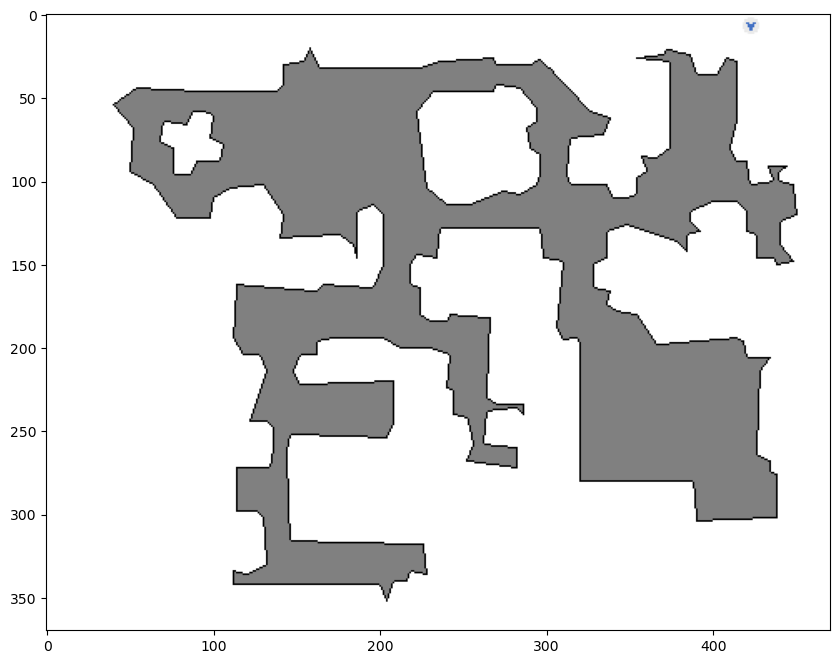

In [157]:
# @markdown ###Configure Example Parameters:
# @markdown Configure the map resolution:
meters_per_pixel = 0.025  # @param {type:"slider", min:0.01, max:1.0, step:0.01}
# @markdown ---
# @markdown Customize the map slice height (global y coordinate):
custom_height = False  # @param {type:"boolean"}
height = 1  # @param {type:"slider", min:-10, max:10, step:0.1}
# @markdown If not using custom height, default to scene lower limit.
# @markdown (Cell output provides scene height range from bounding box for reference.)

print("The NavMesh bounds are: " + str(sim.pathfinder.get_bounds()))
if not custom_height:
    # get bounding box minimum elevation for automatic height
    height = sim.pathfinder.get_bounds()[0][1]

if not sim.pathfinder.is_loaded:
    print("Pathfinder not initialized, aborting.")
else:
    if display:
        hablab_topdown_map = maps.get_topdown_map(
            sim.pathfinder, height, meters_per_pixel=meters_per_pixel
        )
        recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        hablab_topdown_map = recolor_map[hablab_topdown_map]

        grid_dimensions = (hablab_topdown_map.shape[0], hablab_topdown_map.shape[1])
        agent_grid_pos = maps.to_grid(scene_pos[2], scene_pos[0], grid_dimensions, pathfinder=sim.pathfinder)
        maps.draw_agent(hablab_topdown_map, agent_grid_pos, agent_rotation, agent_radius_px=5)

        
        #print("Displaying the map from the Habitat-Lab maps module:")
        display_map(hablab_topdown_map)
        
        # easily save a map to file:
        #map_filename = f"top_down_map.png"
        #imageio.imsave(f'/home/wes/Documents/test_development/outputs/{map_filename}', hablab_topdown_map)

In [62]:
df_instruction[df_instruction['instruction_id']==instruction_id]['instruction'].iloc[0]

"You begin looking towards a corner with a very interesting... I wanna call it a mural but it's not... It's kinda like a collage of words on your right. It's one of the- one of the art pieces that I've seen in this thing that I- I actually kinda like that one, y'know? It has artistic merit to it, it's not just blobs and splatters... And a window to the left! Turn around completely and move towards what looks like a copy of the last supper, and then turn right and move to the near left corner of the dining table with a bunch of black chairs around it. Once you've moved towards that once you won't really be quite to it but you're gonna move towards the far left corner now, just passing it on your right. Continue, go around the staircase in front of you to the head of the stairs, and you're gonna go down that staircase.Once you've reached the bottom of the staircase, the electric guitar and Einstein, turn and enter the open door to the left, and as soon as you're in there, just go straigh

In [158]:
agent = sim.get_agent(0)

In [159]:
agent_state = habitat_sim.AgentState()

In [160]:
agent_state.position = scene_pos
agent_state.rotation = utils.quat_from_magnum(rotation_quaternion)

In [161]:
agent.set_state(agent_state)

In [162]:
observations = sim.get_sensor_observations()

In [163]:
rgb = observations['color_sensor']
depth = observations['depth_sensor']

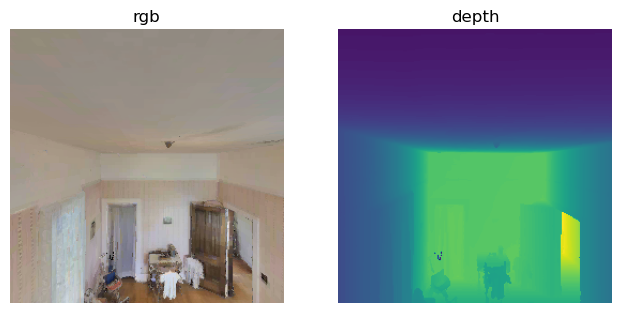

In [164]:
display_sample(rgb, np.array([]), depth)

In [165]:
sim.pathfinder.is_navigable(scene_pos)

False

In [166]:
print(agent.get_state().position)
print(scene_pos)

[ 8.95555  1.5752  -1.73655]
[ 8.95555019  1.57519996 -1.73654997]
